In [9]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Gắn kết Google Drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/MyDrive/Database/data/1.agedetector_group_train.v1.0.txt'
test_path = '/content/gdrive/MyDrive/Database/data/1agedetector_group_test.v1.0.txt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from collections import Counter

# Hàm để tải dữ liệu từ file
def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        label = parts[0].replace('__label__', '')
        user_ids = parts[1:]
        data.append((label, user_ids, len(parts) - 1))

    return pd.DataFrame(data, columns=['age_group', 'group_ids', 'count'])


# Tải dữ liệu
df = load_data(train_path)
df_test = load_data(test_path)

In [ ]:
from collections import Counter

import numpy as np

def matrix_feature(x, list_gr, min_, max_, x_check=None):
    """
    Tạo ma trận đặc trưng từ danh sách các nhóm.

    Parameters:
    x (list): Danh sách các nhóm.
    list_gr (list): Danh sách các nhãn nhóm cần kiểm tra.
    x_check (list, optional): Danh sách các giá trị kiểm tra.
     Nếu không được cung cấp, mặc định là mảng toàn giá trị 1.
    min_ (int): Giá trị nhỏ nhất của độ dài nhóm.
    max_ (int): Giá trị lớn nhất của độ dài nhóm.

    Returns:
    np.array: Ma trận đặc trưng.
    """
    # Nếu x_check không được truyền vào, tạo một mảng toàn giá trị 1
    if x_check is None:
        x_check = np.ones(len(x))

    data_list = []
    for gr, check in zip(x, x_check):
        if check == -1:
            continue
        else:
            arr_data = []
            for gr_label in list_gr:
                arr_data.append(1 if gr_label in gr else 0)

            if (len(gr) - 1) <= 5:
               arr_data.append(0)
            else:
               arr_data.append(1)
            # # arr_data.append((len(gr) - 1) / (max_ - min_))
            data_list.append(arr_data)

    data_matrix = np.array(data_list)

    return data_matrix

#trả về từ điển với key là các group_id và value là số lần xuất hiện
def getDictGroup(dataframe):
    list_ = []
    for x in dataframe:
        list_.extend(x)

    counter = Counter(list_)

    # Chuyển Counter thành dictionary
    result_dict = dict(counter)
    return result_dict

result_dict = getDictGroup(df['group_ids'])

#lấy về n phần từ có số lần xuất hiện nhiều nhất.
def getTopMost(result_dict, n):
    # Lấy top n giá trị xuất hiện nhiều nhất
    top_n = Counter(result_dict).most_common(n)

    # Chỉ lấy các key
    top_n_keys = [key for key, value in top_n]
    return top_n_keys

# Tạo set để lưu trữ các key có value từ n1 đến n2
def getTop(result_dict, n1, n2):
  list_gr = {k for k,
             v in result_dict.items() if n1 <= v <= n2}
  return list_gr


def getAcc(model, matrix_test, test):
    """
    model: mô hình cần dự đoán
    matrix_test: đặc trưng cần dự đoán
    test: label
    """
    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(matrix_test)

    # Đánh giá mô hình
    accuracy = accuracy_score(test, y_pred)
    print('Classification Report:')
    print(classification_report(test, y_pred))

    def accept_matrix_acc(matrix):
        x = 0
        y = 0
        rows, cols = matrix.shape
        if rows != cols:
            return -1
        else:
            for i in range(rows):
                x += matrix[i][i]  # Thêm giá trị trên đường chéo chính
                if i - 1 >= 0:
                    x += matrix[i][i-1]  # Thêm giá trị lân cận bên trái
                if i + 1 < cols:
                    x += matrix[i][i+1]  # Thêm giá trị lân cận bên phải
            for i in range(rows):
                for j in range(rows):
                    y += matrix[i][j]
            return x / y

    def my_confusion_matrix(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        N = np.unique(y_true).shape[0]
        cm = np.zeros((N, N))
        for n in range(y_true.shape[0]):
            cm[int(y_true[n]), int(y_pred[n])] += 1
        return cm

    # Tính ma trận nhầm lẫn
    cnf_matrix = my_confusion_matrix(test, y_pred)
    x = accept_matrix_acc(cnf_matrix)
    print('\nĐộ chấp nhận được:', x)

    # Tính độ chính xác từ ma trận nhầm lẫn
    accuracy_from_cnf_matrix = np.diagonal(cnf_matrix).sum() / cnf_matrix.sum()
    print('\nAcc:', accuracy_from_cnf_matrix)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(4, 3))
    sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
age_groups = df['age_group'].unique()
dataframes = {age_group: df[df['age_group'] == age_group] for age_group in age_groups}

df_18_24 = dataframes['18-24']
df_25_34 = dataframes['25-34']
df_35_44 = dataframes['35-44']
df_45_54 = dataframes['45-54']
df_55_plus = dataframes['55+']

list_gr1 = getTopMost(getDictGroup(df_18_24['group_ids']), 1500)
list_gr2 = getTopMost(getDictGroup(df_25_34['group_ids']), 1500)
list_gr3 = getTopMost(getDictGroup(df_35_44['group_ids']), 1500)
list_gr4 = getTopMost(getDictGroup(df_45_54['group_ids']), 1500)
list_gr5 = getTopMost(getDictGroup(df_55_plus['group_ids']), 1500)

In [ ]:
list_gr = getTop(result_dict, 19, 390)
len(list_gr)
list_gr_single = set(list_gr1 + list_gr2 + list_gr3 + list_gr4 + list_gr5)
list_gr = list_gr_single

In [ ]:
# Danh sách các nhãn theo thứ tự mong muốn
ordered_labels = ['18-24', '25-34', '35-44', '45-54', '55+']

def prepare_data(df, df_test, list_gr, ordered_labels):
    """
    Chuẩn bị dữ liệu huấn luyện và kiểm tra từ các DataFrame đầu vào.

    Parameters:
    df (DataFrame): DataFrame huấn luyện.
    df_test (DataFrame): DataFrame kiểm tra.
    list_gr (list): Danh sách các nhóm đặc trưng.
    ordered_labels (list): Danh sách các nhãn theo thứ tự mong muốn.

    Returns:
    matrix_train (ndarray): Ma trận đặc trưng huấn luyện.
    matrix_test (ndarray): Ma trận đặc trưng kiểm tra.
    train (ndarray): Nhãn huấn luyện.
    test (ndarray): Nhãn kiểm tra.
    """
    # Tính giá trị min và max của cột 'count'
    max_ = df['count'].max()
    min_ = df['count'].min()

    # Tạo ma trận đặc trưng cho tập huấn luyện và kiểm tra
    matrix_train = matrix_feature(df['group_ids'], list_gr, min_, max_)
    matrix_test = matrix_feature(df_test['group_ids'], list_gr, min_, max_)

    # Tạo ma trận nhãn cho tập huấn luyện
    train = np.array([ordered_labels.index(age) for age in df['age_group']])

    # Tạo ma trận nhãn cho tập kiểm tra
    test = np.array([ordered_labels.index(age) for age in df_test['age_group']])

    return matrix_train, matrix_test, train, test

# Ví dụ sử dụng hàm
matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.69      3801
           1       0.50      0.49      0.50      3176
           2       0.50      0.37      0.42      2671
           3       0.39      0.67      0.50      2990
           4       0.40      0.12      0.18      1130

    accuracy                           0.52     13768
   macro avg       0.51      0.46      0.46     13768
weighted avg       0.54      0.52      0.51     13768


Độ chấp nhận được: 0.8115920976176642

Acc: 0.5183033120278907


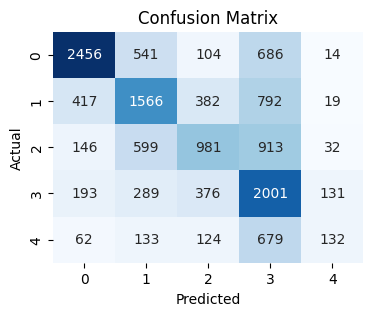

In [ ]:

import seaborn as sns
# Huấn luyện mô hình Logistic Regression
model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(matrix_train, train)


getAcc(model_lgt, matrix_test, test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()
model_nb.fit(matrix_train, train)
getAcc(model_nb, matrix_test, test)

In [ ]:
from sklearn.svm import SVC
# Khởi tạo mô hình SVM với kernel là 'rbf' (radial basis function)
model_SVM = SVC(kernel='rbf', decision_function_shape='ovr')
model_SVM.fit(matrix_train, train)
getAcc(model_SVM, matrix_test, test)

#Sử dụng giải pháp 1: over sampling group 5


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Sinh ra mẫu dựa trên xác suất nhóm
def generate_samples(top_groups, probabilities, num_samples, num_groups):
    samples = []
    # Chuyển xác suất thành danh sách và chuẩn hóa để tổng xác suất bằng 1
    prob_values = np.array([probabilities.get(group, 0) for group in top_groups])
    total_prob = prob_values.sum()

    # Điều chỉnh xác suất còn thiếu
    if total_prob < 1:
        # Xác suất còn thiếu
        remaining_prob = 1 - total_prob
        # Chia đều xác suất còn thiếu cho các nhóm
        prob_values += remaining_prob / len(top_groups)

    # Chuẩn hóa xác suất
    prob_values /= prob_values.sum()  # Đảm bảo tổng xác suất bằng 1

    for _ in range(num_samples):
        # Sinh số lượng nhóm cho mỗi mẫu
        num_groups_in_sample = np.random.poisson(lam=num_groups)
        sample = np.random.choice(top_groups, size=num_groups_in_sample, p=prob_values)
        samples.append(sample.tolist())
    return samples


# Bước 1: Tính số lần xuất hiện và chọn 500 nhóm xuất hiện nhiều nhất
dict_group = getDictGroup(df_55_plus['group_ids'])
top_500_groups = getTopMost(dict_group, 500)

# Bước 2: Tính xác suất của các nhóm trong top 500
total_counts = len(df_55_plus['group_ids'])
probabilities = {group: dict_group.get(group, 0) / total_counts for group in top_500_groups}

# Bước 3: Sinh ra 3000 mẫu với số lượng các nhóm trong mỗi mẫu dựa vào xác suất
num_samples = 3000
num_groups_per_sample = np.mean([dict_group.get(group, 0) for group in top_500_groups])
samples = generate_samples(top_500_groups, probabilities, num_samples, num_groups_per_sample)

# Bước 4: Chuyển đổi mẫu thành DataFrame với các cột age_group, group_ids, counts
data = []
age_group = '55+'  # Hoặc giá trị tương ứng

for sample in samples:
    group_ids = sample
    counts = len(group_ids)
    data.append([age_group, group_ids, counts])

# Tạo DataFrame
samples_df = pd.DataFrame(data, columns=['age_group', 'group_ids', 'counts'])



In [ ]:
df = pd.concat([df, samples_df], ignore_index=True)


In [ ]:
matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      8908
           1       0.77      0.60      0.67      7296
           2       0.77      0.55      0.64      6268
           3       0.46      0.85      0.60      6992
           4       0.94      0.72      0.82      5658

    accuracy                           0.70     35122
   macro avg       0.76      0.69      0.70     35122
weighted avg       0.76      0.70      0.71     35122


Độ chấp nhận được: 0.8494960423666078

Acc: 0.6964295882922384


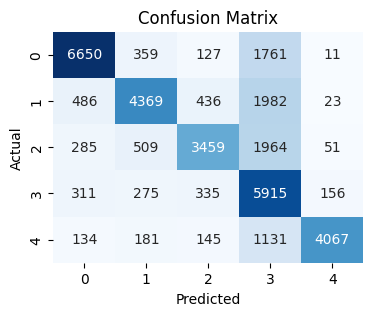

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(matrix_train, train)


getAcc(model_lgt, matrix_test, test)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69      3801
           1       0.57      0.40      0.47      3176
           2       0.47      0.39      0.43      2671
           3       0.54      0.37      0.44      2990
           4       0.14      0.53      0.22      1130

    accuracy                           0.46     13768
   macro avg       0.50      0.46      0.45     13768
weighted avg       0.57      0.46      0.50     13768


Độ chấp nhận được: 0.7256682161533992

Acc: 0.46034282393957004


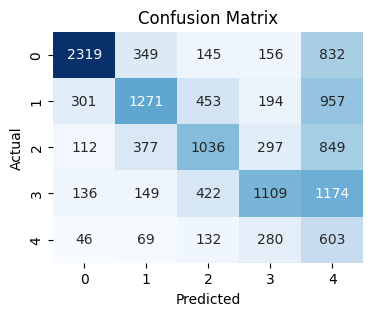

In [ ]:
from imblearn.over_sampling import SMOTE

# Sử dụng SMOTE để cân bằng dữ liệu huấn luyện .
smote = SMOTE(random_state=42)
matrix_train, train = smote.fit_resample(matrix_train, train)

from sklearn.linear_model import LogisticRegression
model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(matrix_train, train)


getAcc(model_lgt, matrix_test, test)

In [ ]:
import matplotlib.pyplot as plt


Vấn đề 1  Loại bỏ các giá trị nhiễu bằng phương pháp IQR


In [ ]:
# Hàm để xác định các điểm ngoại lai bằng phương pháp IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  max(2, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < max(2, Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Giới hạn dưới: {lower_bound}")
    print(f"Giới hạn trên: {upper_bound}")
    return outliers


# def find_outliers_iqr(df, column):
#     mean = df[column].mean()
#     std = df[column].std()
#     z_scores = (df[column] - mean) / std
#     outliers = df[(z_scores > 3) | (z_scores < -3)]
#     return outliers


# Xác định các điểm ngoại lai cho từng nhóm tuổi
outliers_18_24 = find_outliers_iqr(df[df['age_group'] == '18-24'], 'count')
outliers_25_34 = find_outliers_iqr(df[df['age_group'] == '25-34'], 'count')
outliers_35_44 = find_outliers_iqr(df[df['age_group'] == '35-44'], 'count')
outliers_45_54 = find_outliers_iqr(df[df['age_group'] == '45-54'], 'count')
outliers_55_plus = find_outliers_iqr(df[df['age_group'] == '55+'], 'count')

# Kết hợp tất cả các điểm ngoại lai
all_outliers = pd.concat([outliers_18_24, outliers_25_34, outliers_35_44, outliers_45_54, outliers_55_plus])

# Loại bỏ các điểm ngoại lai khỏi DataFrame gốc
df = df[~df.index.isin(all_outliers.index)]

matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)


Giới hạn dưới: 2
Giới hạn trên: 96.0
Giới hạn dưới: 2
Giới hạn trên: 85.0
Giới hạn dưới: 2
Giới hạn trên: 64.0
Giới hạn dưới: 2
Giới hạn trên: 34.5
Giới hạn dưới: 2
Giới hạn trên: 24.5


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      3801
           1       0.50      0.50      0.50      3176
           2       0.48      0.36      0.41      2671
           3       0.39      0.65      0.49      2990
           4       0.38      0.10      0.16      1130

    accuracy                           0.51     13768
   macro avg       0.50      0.45      0.45     13768
weighted avg       0.53      0.51      0.50     13768


Độ chấp nhận được: 0.806725740848344

Acc: 0.5131464264962231


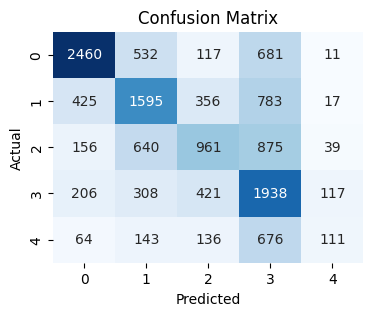

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(matrix_train, train)


getAcc(model_lgt, matrix_test, test)

Vấn đề 2:  Sử dụng mô hình để dự đoán ra các điểm ngoại lại và bỏ các giá trị đó

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69      3801
           1       0.49      0.52      0.50      3176
           2       0.47      0.37      0.41      2671
           3       0.40      0.65      0.49      2990
           4       0.41      0.10      0.16      1130

    accuracy                           0.51     13768
   macro avg       0.51      0.45      0.45     13768
weighted avg       0.54      0.51      0.51     13768


Độ chấp nhận được: 0.8090499709471237

Acc: 0.5143811737361998


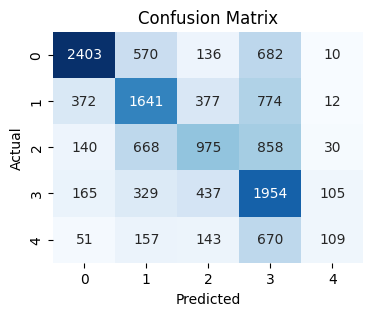

In [ ]:
matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)
model_lgt = LogisticRegression(max_iter=1000, random_state=42)
model_lgt.fit(matrix_train, train)
# Dự đoán trên tập huấn luyện

y_train_pred = model_lgt.predict(matrix_train)

# Tính toán phần dư (residuals)
residuals = train - y_train_pred

# Xác định ngưỡng để loại bỏ nhiễu (ví dụ: 2 lần độ lệch chuẩn của phần dư)
threshold =  2*  np.std(residuals)

# Loại bỏ các điểm dữ liệu có phần dư lớn hơn ngưỡng
matrix_train_cleaned = matrix_train[np.abs(residuals) <= threshold]
train_cleaned = train[np.abs(residuals) <= threshold]

model_lgt2 = LogisticRegression(max_iter=1000)
model_lgt2.fit(matrix_train_cleaned, train_cleaned)

getAcc(model_lgt2, matrix_test, test)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      7666
           1       0.66      0.67      0.66      6120
           2       0.69      0.59      0.64      5095
           3       0.51      0.77      0.61      5319
           4       0.91      0.37      0.52      2002

    accuracy                           0.68     26202
   macro avg       0.73      0.63      0.65     26202
weighted avg       0.71      0.68      0.68     26202


Độ chấp nhận được: 0.8555072131898328

Acc: 0.6766277383405847


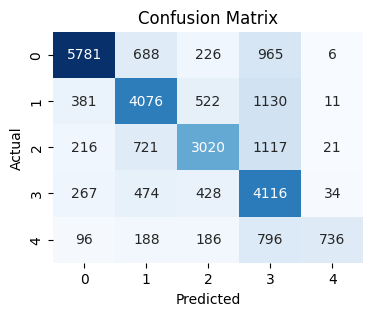

In [ ]:
getAcc(model_lgt2, matrix_train, train)

Vấn đề 3: số lượng nhóm mà 1 người dùng tham gia

```
# This is formatted as code
```



In [ ]:
# Hàm để tải dữ liệu từ file
def getCount(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        label = parts[0].replace('__label__', '')
        data.append((label, len(parts) - 1))

    return pd.DataFrame(data, columns=['age_group', 'count'])

df_count = getCount(train_path)

In [ ]:
df_18_24['count'].describe()

,count
count,8908.000000
mean,33.881343
std,52.816522
min,1.000000
25%,6.000000
50%,17.000000
75%,42.000000
max,1000.000000


Vấn đề 4:Tạo dữ liệu đặc trưng từ các nhóm trùng lặp




In [ ]:
def getDiff(list_1, list_2):
  return list(set(list_1) & set(list_2))


lists = [list_gr1, list_gr2, list_gr3, list_gr4, list_gr5]

# Tạo ma trận để lưu trữ số lượng phần tử chung
n = len(lists)
matrix = [[0] * n for _ in range(n)]

# Điền giá trị vào ma trận
for i in range(n):
    for j in range(i, n):
        if i != j:
            common_elements = getDiff(lists[i], lists[j])
            matrix[i][j] = len(common_elements)
            matrix[j][i] = len(common_elements)

# Hiển thị ma trận
for row in matrix:
    print(row)

[0, 480, 325, 200, 143]
[480, 0, 694, 237, 182]
[325, 694, 0, 534, 350]
[200, 237, 534, 0, 663]
[143, 182, 350, 663, 0]


In [ ]:
len(list_gr)

4867

In [ ]:
x1 = getTopMost(getDictGroup(df_18_24['group_ids']), 15)
x2 = getTopMost(getDictGroup(df_25_34['group_ids']), 15)
x3 = getTopMost(getDictGroup(df_35_44['group_ids']), 15)
x4= getTopMost(getDictGroup(df_45_54['group_ids']), 15)
x5 = getTopMost(getDictGroup(df_55_plus['group_ids']), 15)
# Chuyển đổi các danh sách thành tập hợp
set_x1 = set(x1)
set_x2 = set(x2)
set_x3 = set(x3)
set_x4 = set(x4)
set_x5 = set(x5)

# Thực hiện phép trừ các phần tử giao nhau
list_gr = set(list_gr) - (set_x1 & set_x2) - (set_x2 & set_x3) - (set_x3 & set_x4) - (set_x4 & set_x5)

# Chuyển đổi kết quả trở lại thành danh sách nếu cần
list_gr = list(list_gr)
print(len(list_gr))
matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)

4852


In [ ]:
from sklearn.linear_model import LogisticRegression
model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(matrix_train, train)


LogisticRegression(max_iter=1000)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      3801
           1       0.50      0.50      0.50      3176
           2       0.49      0.36      0.42      2671
           3       0.39      0.66      0.49      2990
           4       0.40      0.12      0.18      1130

    accuracy                           0.52     13768
   macro avg       0.51      0.46      0.46     13768
weighted avg       0.53      0.52      0.51     13768


Độ chấp nhận được: 0.8083236490412551

Acc: 0.5151074956420686


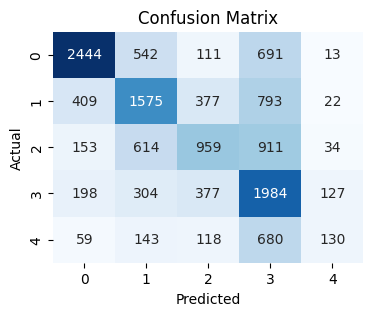

In [ ]:
getAcc(model_lgt, matrix_test, test)

Vấn đề 5:Độ dài của các group_id

In [ ]:
from collections import Counter

# Hàm để tải dữ liệu từ file
def load_data_(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        parts = line.strip().split()
        label = parts[0].replace('__label__', '')
        user_ids = parts[1:]
        data_x = []
        for x in user_ids:
          data_x.append(len(x))
        data.append((label, data_x))

    return pd.DataFrame(data, columns=['age_group','len'])


# Tải dữ liệu
df_ = load_data_(train_path)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def getLen(df):
    # Khởi tạo các cột mới với giá trị ban đầu là 0
    keys = ['10', '11', '12', '15', '16', '17']
    for key in keys:
        df[key] = 0

    # Duyệt qua từng hàng trong DataFrame
    for index, row in df.iterrows():
        # Khởi tạo từ điển để lưu trữ số lần xuất hiện của các phần tử trong hàng hiện tại
        frequency_dict = dict.fromkeys(keys, 0)
        for i in row['len']:
            if str(i) in frequency_dict:
                frequency_dict[str(i)] += 1

        # Cập nhật giá trị vào DataFrame
        for key in keys:
            df.at[index, key] = frequency_dict[key]

    return df



df_ = getLen(df_)
# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = ['10', '11', '12', '15', '16', '17']
df_[columns_to_normalize] = scaler.fit_transform(df_[columns_to_normalize])
df_test_ = load_data_(test_path)
df_test_ = getLen(df_test_)
df_test_[columns_to_normalize] = scaler.fit_transform(df_test_[columns_to_normalize])
# Lấy các cột đã chuẩn hóa ra thành ma trận
matrix_ = df_[columns_to_normalize].to_numpy()
matrix_test_ = df_test_[columns_to_normalize].to_numpy()


In [ ]:
matrix_train, matrix_test, train, test = prepare_data(df, df_test, list_gr, ordered_labels)

model_lgt = LogisticRegression(max_iter=1000)
model_lgt.fit(np.hstack((matrix_train, matrix_)), train)

LogisticRegression(max_iter=1000)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      3801
           1       0.50      0.50      0.50      3176
           2       0.50      0.37      0.42      2671
           3       0.40      0.67      0.50      2990
           4       0.41      0.12      0.18      1130

    accuracy                           0.52     13768
   macro avg       0.51      0.46      0.46     13768
weighted avg       0.54      0.52      0.51     13768


Độ chấp nhận được: 0.8118826263800116

Acc: 0.5202643811737362


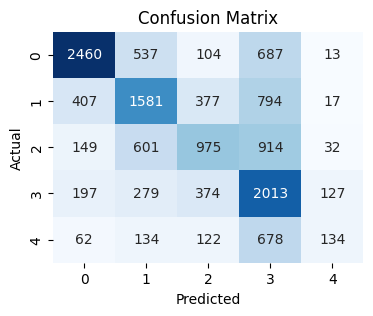

In [ ]:
getAcc(model_lgt, np.hstack((matrix_test,matrix_test_)), test)

Sử dụng việc loại bỏ nhiễu

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      3801
           1       0.50      0.51      0.50      3176
           2       0.49      0.37      0.42      2671
           3       0.40      0.68      0.50      2990
           4       0.43      0.11      0.17      1130

    accuracy                           0.52     13768
   macro avg       0.52      0.46      0.46     13768
weighted avg       0.54      0.52      0.51     13768


Độ chấp nhận được: 0.8117373619988378

Acc: 0.5182306798373039


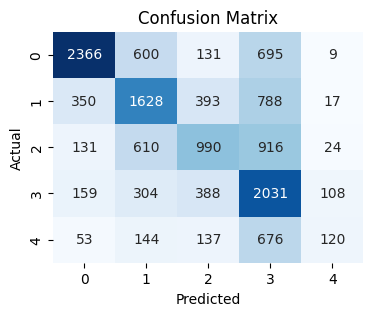

In [ ]:
model_lgt = LogisticRegression(max_iter=1000, random_state=42)
x = np.hstack((matrix_train, matrix_))
model_lgt.fit(x, train)
# Dự đoán trên tập huấn luyện

y_train_pred = model_lgt.predict(x)

# Tính toán phần dư (residuals)
residuals = train - y_train_pred

# Xác định ngưỡng để loại bỏ nhiễu (ví dụ: 2 lần độ lệch chuẩn của phần dư)
threshold =  2*  np.std(residuals)

# Loại bỏ các điểm dữ liệu có phần dư lớn hơn ngưỡng
matrix_train_cleaned = x[np.abs(residuals) <= threshold]
train_cleaned = train[np.abs(residuals) <= threshold]

model_lgt2 = LogisticRegression(max_iter=1000)
model_lgt2.fit(matrix_train_cleaned, train_cleaned)

y = np.hstack((matrix_test,matrix_test_))
getAcc(model_lgt2, y, test)

Vấn đề

In [ ]:
!pip install lightgbm
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 2.0 MB/s eta 0:00:00


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.389319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8343
[LightGBM] [Info] Number of data points in the train set: 32122, number of used features: 3959
[LightGBM] [Info] Start training from score -1.282591
[LightGBM] [Info] Start training from score -1.482215
[LightGBM] [Info] Start training from score -1.634084
[LightGBM] [Info] Start training from score -1.524775
[LightGBM] [Info] Start training from score -2.491967
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.69      3801
           1       0.49      0.54      0.51      3176
           2       0.49      0.34      0.40      2671
           3       0.40      0.65      0.49      2990
           4       0.37      0.10      0.16      1130

    accuracy              

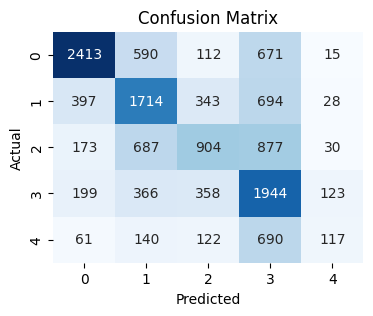

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=5, random_state=42, learning_rate = 0.31)
lgb_model.fit(x, train)

getAcc(lgb_model, y, test)